In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score,cross_validate, RandomizedSearchCV, train_test_split
import optuna
import xgboost as xgb
from sklearn.metrics import r2_score 
import joblib

In [2]:
df2 = pd.read_excel("../markaFile/Opel.xlsx",sheet_name="Sheet1")

In [3]:
df2.drop("Unnamed: 0",axis=1, inplace=True)

In [4]:
df2.head()

,Fiyat,Yıl,Motor Gücü,Motor Hacmi,Kilometre,Boya,Değişen,Seri_Agila,Seri_Ascona,Seri_Astra,...,Model_2.5 CDX,Model_2.5 TD,Model_2.8 Sport,Model_GT 2.0 Turbo,Yakıt Tipi_Benzin,Yakıt Tipi_Dizel,Yakıt Tipi_LPG & Benzin,Vites Tipi_Düz,Vites Tipi_Otomatik,Vites Tipi_Yarı Otomatik
0,448000,2012,85,1229,95000,0.0,1.0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1,395000,2012,85,1229,80000,5.0,4.0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,579650,2016,90,1398,111000,NaN,NaN,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,243500,1997,90,1389,157672,NaN,NaN,0,0,0,...,0,0,0,0,0,0,1,0,1,0
4,551500,2015,75,1248,97000,0.0,0.0,0,0,0,...,0,0,0,0,0,1,0,1,0,0


In [5]:
y = df2["Fiyat"]
X = df2.drop(["Fiyat"], axis=1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [7]:
def set_model(model_list, X_train, X_test, y_train, y_test):
    dataf = pd.DataFrame()

    for i in range(len(model_list)):
        algo_name = model_list[i][0]
        algo = model_list[i][1]

        model = algo.fit(X_train, y_train)

        cv_result = cross_val_score(model,
                                    X_train, y_train,
                                    cv=5,
                                    scoring="neg_mean_squared_error")

        y_pred = model.predict(X_test)
        rmse = np.mean(np.sqrt(-cv_result))
        data_list = {"Model": algo_name,
                     "TestDeger": rmse,
                     "MSE":mean_squared_error(y_test, y_pred),
                     "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
                     "MAE": mean_absolute_error(y_test, y_pred)}
        dataf = dataf.append(data_list, ignore_index=True)

    return dataf

In [8]:
models = []
#models.append(('Gradient Boosting Regressor', GradientBoostingRegressor()))
models.append(('XGBModel', XGBRegressor(objective="reg:squarederror",use_label_encoder=False)))
#models.append(('LGBMModel', LGBMRegressor(use_missing=False)))
#models.append(('LRModel', LinearRegression()))
#models.append(('RFModel', RandomForestRegressor()))

In [9]:
df2_model = set_model(models, X_train, X_test, y_train, y_test)
df2_model

C:\Users\senab\AppData\Local\Temp\ipykernel_9308\3059390516.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataf = dataf.append(data_list, ignore_index=True)


,Model,TestDeger,MSE,RMSE,MAE
0,XGBModel,51295.481172,1.774648e+09,42126.565491,30560.294008


In [10]:
def objective(n_trials):
  params = {
        'colsample_bytree': n_trials.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': n_trials.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        "learning_rate": n_trials.suggest_float("learning_rate", 1e-4, 0.5, log=True),
        'n_estimators': 10000,
        "max_depth": n_trials.suggest_int("max_depth", 3, 15),
        'min_child_weight': n_trials.suggest_int('min_child_weight', 1, 300),
    }
  dtrain = xgb.DMatrix(data = X_train, label = y_train)
  dval = xgb.DMatrix(data = X_test, label = y_test)

  regressor = xgb.train(params, dtrain) 
  y_pred = regressor.predict(dval)
  rmse = mean_squared_error(y_test, y_pred, squared=False)

  return rmse

In [11]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=250, n_jobs=-1)

[I 2023-10-08 14:19:36,105] A new study created in memory with name: no-name-eeff1e7e-3cb2-4820-be16-7a1fb4cb4cc5
[I 2023-10-08 14:19:36,368] Trial 0 finished with value: 450902.7369450916 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.00027841574676680883, 'max_depth': 6, 'min_child_weight': 269}. Best is trial 0 with value: 450902.7369450916.
[I 2023-10-08 14:19:36,368] Trial 5 finished with value: 447793.5974551793 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.5, 'learning_rate': 0.0010641234734706172, 'max_depth': 14, 'min_child_weight': 269}. Best is trial 5 with value: 447793.5974551793.
[I 2023-10-08 14:19:36,411] Trial 1 finished with value: 450869.66484456876 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.6, 'learning_rate': 0.00029649954725070735, 'max_depth': 12, 'min_child_weight': 244}. Best is trial 5 with value: 447793.5974551793.
[I 2023-10-08 14:19:36,446] Trial 6 finished with value: 364901.535340908 and parameters:

[I 2023-10-08 14:19:37,963] Trial 28 finished with value: 51005.30572056223 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.3846788315790412, 'max_depth': 8, 'min_child_weight': 36}. Best is trial 16 with value: 48404.60408025947.
[I 2023-10-08 14:19:38,003] Trial 30 finished with value: 50630.599342784284 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.49677885791233717, 'max_depth': 8, 'min_child_weight': 34}. Best is trial 16 with value: 48404.60408025947.
[I 2023-10-08 14:19:38,033] Trial 32 finished with value: 170501.8994196579 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.09996841853577304, 'max_depth': 8, 'min_child_weight': 38}. Best is trial 16 with value: 48404.60408025947.
[I 2023-10-08 14:19:38,086] Trial 33 finished with value: 173330.37009664785 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.09815557901371713, 'max_depth': 8, 'min_child_weight': 

[I 2023-10-08 14:19:39,980] Trial 59 finished with value: 48301.06354238132 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.28014144560399235, 'max_depth': 9, 'min_child_weight': 14}. Best is trial 56 with value: 44380.26144350865.
[I 2023-10-08 14:19:39,998] Trial 61 finished with value: 68339.97423063671 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.2037436518952176, 'max_depth': 12, 'min_child_weight': 14}. Best is trial 56 with value: 44380.26144350865.
[I 2023-10-08 14:19:40,105] Trial 62 finished with value: 85783.45660031083 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.18470506628340297, 'max_depth': 12, 'min_child_weight': 128}. Best is trial 56 with value: 44380.26144350865.
[I 2023-10-08 14:19:40,286] Trial 63 finished with value: 89968.64593248567 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.17719686835038917, 'max_depth': 7, 'min_child_weight':

[I 2023-10-08 14:19:42,133] Trial 90 finished with value: 57573.97527644057 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.24707982627521885, 'max_depth': 8, 'min_child_weight': 40}. Best is trial 56 with value: 44380.26144350865.
[I 2023-10-08 14:19:42,199] Trial 91 finished with value: 61935.64485623962 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.2628967154714507, 'max_depth': 8, 'min_child_weight': 42}. Best is trial 56 with value: 44380.26144350865.
[I 2023-10-08 14:19:42,230] Trial 92 finished with value: 58112.560206602226 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.24791687868808815, 'max_depth': 8, 'min_child_weight': 41}. Best is trial 56 with value: 44380.26144350865.
[I 2023-10-08 14:19:42,419] Trial 93 finished with value: 58693.91157651692 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.24006099583307874, 'max_depth': 13, 'min_child_weight': 

[I 2023-10-08 14:19:44,334] Trial 117 finished with value: 43020.56255714882 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.4414632713766007, 'max_depth': 10, 'min_child_weight': 15}. Best is trial 108 with value: 42450.2227411348.
[I 2023-10-08 14:19:44,423] Trial 121 finished with value: 81595.66502160078 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.20447907046722, 'max_depth': 10, 'min_child_weight': 226}. Best is trial 108 with value: 42450.2227411348.
[I 2023-10-08 14:19:44,489] Trial 122 finished with value: 43953.52027843097 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.4179068795827483, 'max_depth': 10, 'min_child_weight': 16}. Best is trial 108 with value: 42450.2227411348.
[I 2023-10-08 14:19:44,616] Trial 124 finished with value: 68681.34005258941 and parameters: {'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.20245140648357207, 'max_depth': 10, 'min_child_weight

[I 2023-10-08 14:19:46,791] Trial 150 finished with value: 45096.78524037181 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.49256024120704417, 'max_depth': 9, 'min_child_weight': 15}. Best is trial 108 with value: 42450.2227411348.
[I 2023-10-08 14:19:46,833] Trial 151 finished with value: 45273.44042526704 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.4837951607902105, 'max_depth': 9, 'min_child_weight': 36}. Best is trial 108 with value: 42450.2227411348.
[I 2023-10-08 14:19:46,954] Trial 152 finished with value: 57784.1703449082 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.37101579193673895, 'max_depth': 9, 'min_child_weight': 115}. Best is trial 108 with value: 42450.2227411348.
[I 2023-10-08 14:19:47,126] Trial 153 finished with value: 44445.30298112076 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.48353597609796345, 'max_depth': 9, 'min_child_weight'

[I 2023-10-08 14:19:49,277] Trial 180 finished with value: 55763.89292483938 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.24500118684618116, 'max_depth': 10, 'min_child_weight': 21}. Best is trial 108 with value: 42450.2227411348.
[I 2023-10-08 14:19:49,338] Trial 181 finished with value: 411568.02436896693 and parameters: {'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.009962230577769259, 'max_depth': 10, 'min_child_weight': 76}. Best is trial 108 with value: 42450.2227411348.
[I 2023-10-08 14:19:49,414] Trial 184 finished with value: 54958.10142400178 and parameters: {'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.40999774671407063, 'max_depth': 10, 'min_child_weight': 21}. Best is trial 108 with value: 42450.2227411348.
[I 2023-10-08 14:19:49,459] Trial 182 finished with value: 54613.88085628584 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.24936835269575744, 'max_depth': 10, 'min_child_

[I 2023-10-08 14:19:51,805] Trial 210 finished with value: 43554.63086551327 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.43010540468788655, 'max_depth': 9, 'min_child_weight': 11}. Best is trial 108 with value: 42450.2227411348.
[I 2023-10-08 14:19:51,887] Trial 211 finished with value: 43323.680690782814 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.4273029633737363, 'max_depth': 9, 'min_child_weight': 10}. Best is trial 108 with value: 42450.2227411348.
[I 2023-10-08 14:19:52,065] Trial 212 finished with value: 44247.588604368524 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.4387382951292947, 'max_depth': 9, 'min_child_weight': 17}. Best is trial 108 with value: 42450.2227411348.
[I 2023-10-08 14:19:52,199] Trial 213 finished with value: 281193.56667484675 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.04825856928439237, 'max_depth': 9, 'min_child_weigh

[I 2023-10-08 14:19:54,630] Trial 239 finished with value: 43442.867422783704 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.44155459396890084, 'max_depth': 10, 'min_child_weight': 10}. Best is trial 108 with value: 42450.2227411348.
[I 2023-10-08 14:19:54,706] Trial 241 finished with value: 48441.41505391238 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.274880261744799, 'max_depth': 10, 'min_child_weight': 10}. Best is trial 108 with value: 42450.2227411348.
[I 2023-10-08 14:19:54,775] Trial 243 finished with value: 63564.56100733544 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.2733979684208043, 'max_depth': 10, 'min_child_weight': 184}. Best is trial 108 with value: 42450.2227411348.
[I 2023-10-08 14:19:54,798] Trial 242 finished with value: 43086.84129902068 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.37003036983034704, 'max_depth': 10, 'min_child_wei

In [12]:
print(f"Optimized RMSE: {study.best_value:.4f}")
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

Optimized RMSE: 42450.2227
Best params:
	colsample_bytree: 1.0
	subsample: 1.0
	learning_rate: 0.4181846958171613
	max_depth: 11
	min_child_weight: 3


In [13]:
model = XGBRegressor(objective="reg:squarederror",use_label_encoder=False)


final_model = model.set_params(**study.best_params).fit(X_train,y_train)
    
cv_results = cross_validate(final_model,
                            X_train, y_train,
                            cv=5,
                            scoring="neg_mean_squared_error")
    
y_pred = final_model.predict(X_test)

rmse = (np.sqrt(-cv_results['test_score'])).mean()
data_list = {"TestDeger": rmse,
             "MSE":mean_squared_error(y_test, y_pred),
             "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
             "MAE": mean_absolute_error(y_test, y_pred)}

print(data_list)

{'TestDeger': 53885.49522187776, 'MSE': 1989494728.149149, 'RMSE': 44603.75239987269, 'MAE': 33197.13399194945}


In [14]:
r2 = r2_score(y_test, y_pred)
r2

0.9391870748929284

In [15]:
n= len(X_train)
p =len(X.columns)
adj_R2 = 1- ((1-r2) * (n-1)/(n-p-1))
adj_R2

0.9308869324120984

In [16]:
marka_model = joblib.dump(final_model, "Opel.pkl")

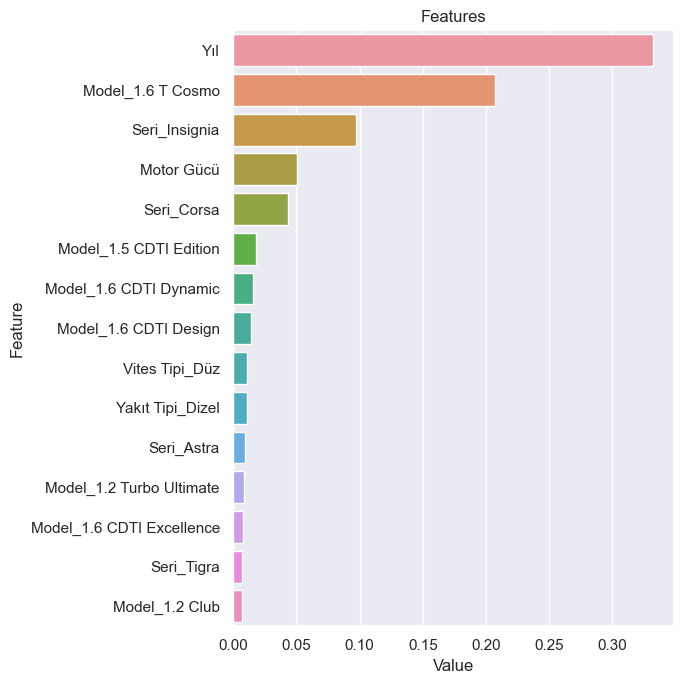

In [17]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(7, 7))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:15])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")
plot_importance(final_model,X)